# Fine-tuning RF-DETR on Crane Hooks Dataset

This notebook walks through the complete process of fine-tuning the RF-DETR (Roboflow DETR) object detection model on the crane hooks dataset imported from Roboflow.

## Overview

1. **Setup** - Install dependencies and configure environment
2. **Data Exploration** - Understand the dataset structure
3. **Data Preparation** - Convert to COCO format for training
4. **Model Configuration** - Set up RF-DETR for fine-tuning
5. **Training** - Fine-tune the model
6. **Evaluation** - Assess model performance
7. **Inference** - Run predictions on new images


## 1. Setup

First, let's install and import the required packages. RF-DETR is built on top of the `rfdetr` package from Roboflow.


In [2]:
# Install rfdetr if not already installed
# !pip install rfdetr supervision

In [ ]:
import json  # noqa
import os  # noqa
import shutil  # noqa
from pathlib import Path  # noqa
from datetime import datetime  # noqa
import random  # noqa

import numpy as np  # noqa
from PIL import Image  # noqa
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

print("Setup complete!")

Setup complete!


## 2. Data Exploration

Let's explore the imported Roboflow dataset. The images are stored in `data/projects/Test/frames/-1/` and annotations are in `data/projects/Test/labels/current/annotations.json`.


In [11]:
# Define paths to the imported data
PROJECT_DIR = Path("data/projects/Test")
FRAMES_DIR = PROJECT_DIR / "frames" / "-1"  # Roboflow imports use video_id = -1
ANNOTATIONS_FILE = PROJECT_DIR / "labels" / "current" / "annotations.json"
PROJECT_CONFIG = PROJECT_DIR / "project.json"

# Verify paths exist
print(f"Frames directory exists: {FRAMES_DIR.exists()}")
print(f"Annotations file exists: {ANNOTATIONS_FILE.exists()}")
print(f"Project config exists: {PROJECT_CONFIG.exists()}")

Frames directory exists: True
Annotations file exists: True
Project config exists: True


In [12]:
# Load project configuration to get class names
with open(PROJECT_CONFIG) as f:
    project_config = json.load(f)

class_names = project_config.get("classes", [])
print(f"Classes in dataset: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Total annotations: {project_config.get('annotation_count', 0)}")
print(f"Total frames: {project_config.get('frame_count', 0)}")

Classes in dataset: ['Chair', 'Person', 'crane hook']
Number of classes: 3
Total annotations: 2072
Total frames: 2054


In [13]:
# Load annotations
with open(ANNOTATIONS_FILE) as f:
    annotations_data = json.load(f)

print(f"Total annotation entries: {len(annotations_data)}")

# Look at a sample annotation
sample_ann_id = list(annotations_data.keys())[0]
print(f"\nSample annotation (ID: {sample_ann_id}):")
print(json.dumps(annotations_data[sample_ann_id], indent=2))

Total annotation entries: 2072

Sample annotation (ID: 1):
{
  "frame_id": 1000000,
  "class_label_id": 0,
  "track_id": null,
  "x": 0.2744140625,
  "y": 0.339111328125,
  "width": 0.039031982421875,
  "height": 0.0980224609375,
  "confidence": 0.73046875,
  "source": "auto",
  "is_exemplar": false,
  "created_at": "2026-01-07T14:17:45.575949",
  "updated_at": "2026-01-07T14:17:45.575971"
}


In [14]:
# Load frames metadata
frames_meta_file = FRAMES_DIR / "frames.json"
with open(frames_meta_file) as f:
    frames_meta = json.load(f)

print(f"Total frames: {len(frames_meta)}")

# Sample frame metadata
sample_frame_id = list(frames_meta.keys())[0]
print(f"\nSample frame metadata (ID: {sample_frame_id}):")
print(json.dumps(frames_meta[sample_frame_id], indent=2))

Total frames: 1991

Sample frame metadata (ID: -1000000):
{
  "video_id": -1,
  "frame_number": 0,
  "timestamp": 0.0,
  "image_path": "data/projects/Test/frames/-1/-1000000.jpg",
  "is_approved": true,
  "needs_review": false,
  "source": "roboflow",
  "original_filename": "1555_jpg.rf.371f955218e03faeb14c8136c22f0a74.jpg",
  "split": "train"
}


In [15]:
# Count annotations per class
class_counts = {i: 0 for i in range(len(class_names))}
for ann in annotations_data.values():
    class_id = ann["class_label_id"]
    if class_id in class_counts:
        class_counts[class_id] += 1

print("Annotations per class:")
for class_id, count in class_counts.items():
    if class_id < len(class_names):
        print(f"  {class_names[class_id]}: {count}")

Annotations per class:
  Chair: 67
  Person: 14
  crane hook: 1991


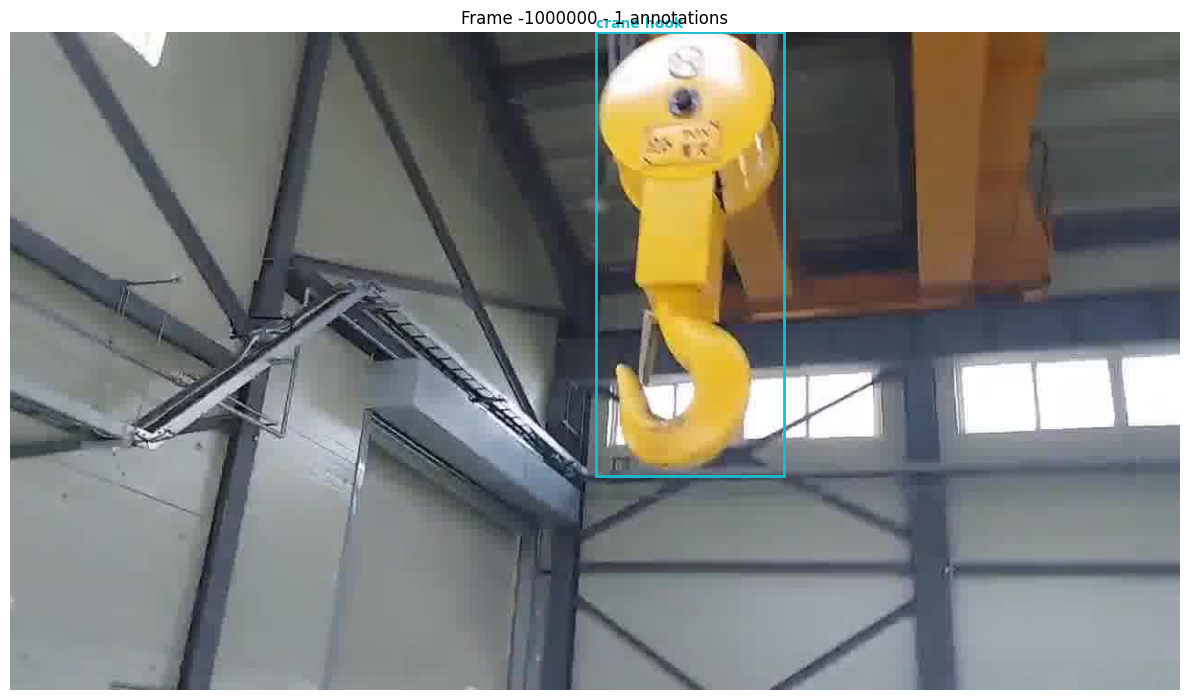

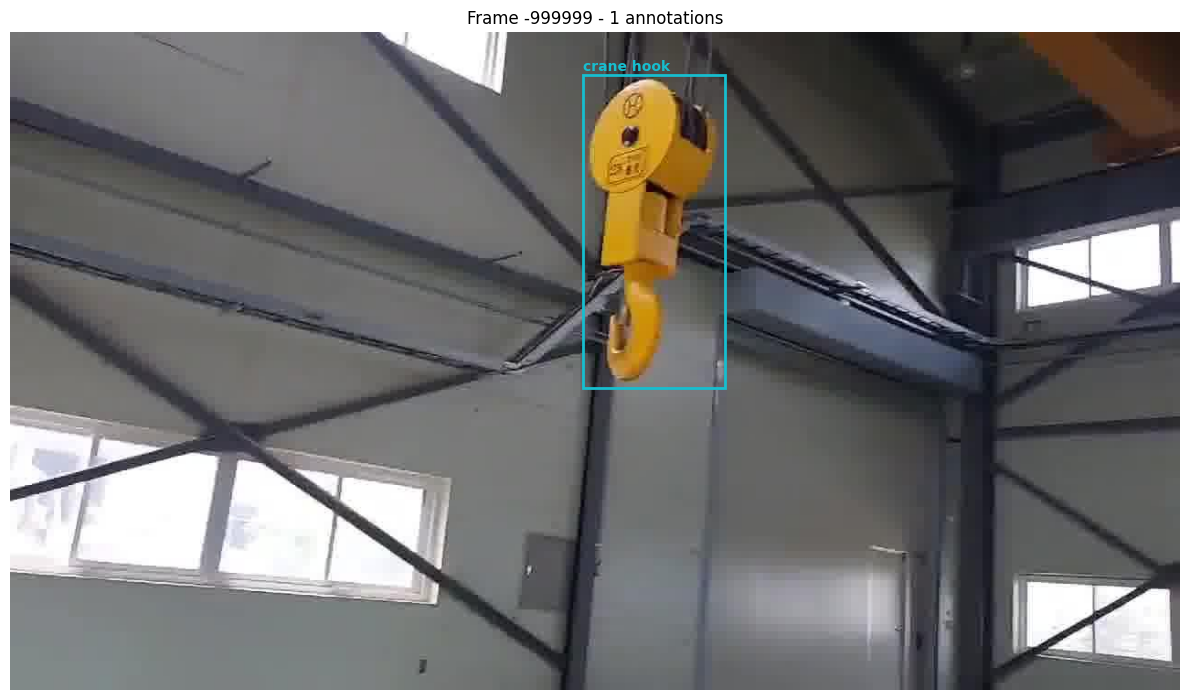

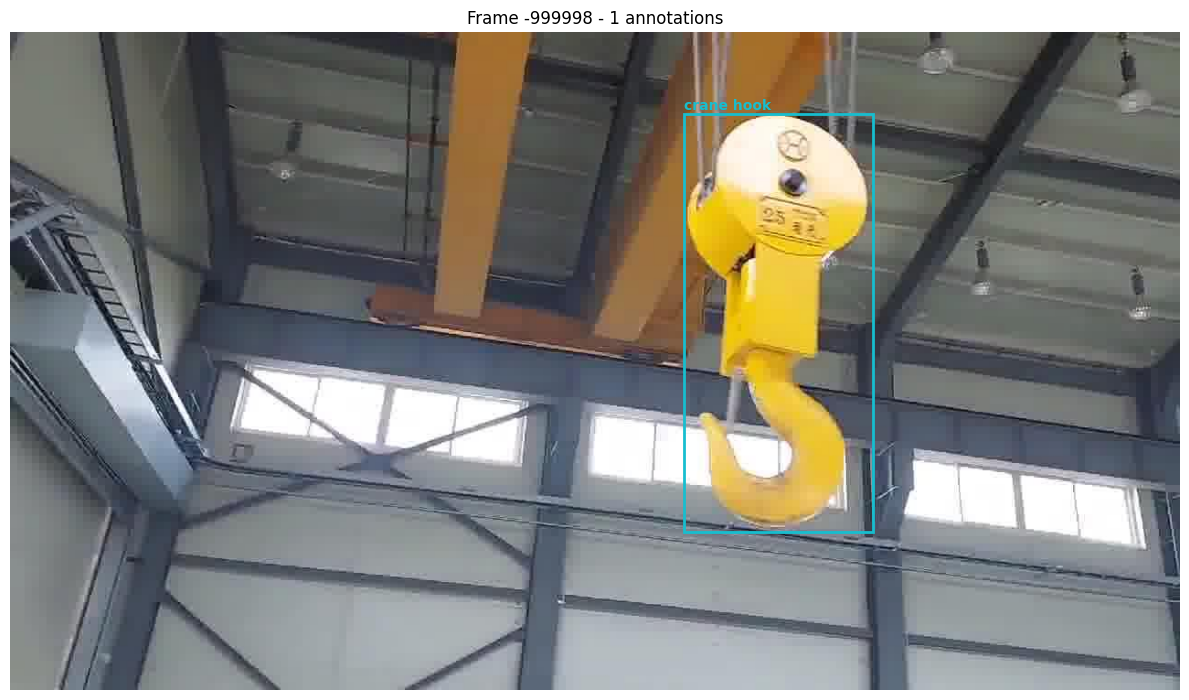

In [16]:
# Visualize a sample image with annotations
def visualize_sample(frame_id, frames_meta, annotations_data, class_names):
    """Visualize a single frame with its annotations."""
    frame_info = frames_meta[str(frame_id)]
    img_path = frame_info["image_path"]

    # Load image
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Get annotations for this frame
    frame_anns = [ann for ann in annotations_data.values() if ann["frame_id"] == frame_id]

    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Draw bounding boxes
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

    for ann in frame_anns:
        # Convert normalized center format to pixel coordinates
        cx, cy = ann["x"] * img_width, ann["y"] * img_height
        w, h = ann["width"] * img_width, ann["height"] * img_height
        x1, y1 = cx - w / 2, cy - h / 2

        class_id = ann["class_label_id"]
        color = colors[class_id % len(colors)]
        class_name = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"

        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, class_name, color=color, fontsize=10, fontweight="bold")

    ax.set_title(f"Frame {frame_id} - {len(frame_anns)} annotations")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    return len(frame_anns)


# Visualize a few samples
frame_ids = list(frames_meta.keys())[:3]
for fid in frame_ids:
    visualize_sample(int(fid), frames_meta, annotations_data, class_names)

## 3. Data Preparation

RF-DETR expects data in COCO format. We need to:

1. Create train/val splits
2. Convert our annotations to COCO format
3. Organize images into the expected directory structure


In [28]:
# Create output directory for COCO dataset
OUTPUT_DIR = Path("datasets/crane_hooks_coco")
TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR = OUTPUT_DIR / "valid"
TEST_DIR = OUTPUT_DIR / "test"

# Clean and create directories
if OUTPUT_DIR.exists():
    shutil.rmtree(OUTPUT_DIR)

TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

print("Created dataset directories:")
print(f"  Train: {TRAIN_DIR}")
print(f"  Val: {VAL_DIR}")
print(f"  Test: {TEST_DIR}")

Created dataset directories:
  Train: datasets/crane_hooks_coco/train
  Val: datasets/crane_hooks_coco/valid
  Test: datasets/crane_hooks_coco/test


In [29]:
# Split frames into train/val/test (70/15/15 split)
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

all_frame_ids = list(frames_meta.keys())
random.shuffle(all_frame_ids)

n_total = len(all_frame_ids)
n_train = int(n_total * TRAIN_SPLIT)
n_val = int(n_total * VAL_SPLIT)
# test gets the remainder

train_frame_ids = set(all_frame_ids[:n_train])
val_frame_ids = set(all_frame_ids[n_train : n_train + n_val])
test_frame_ids = set(all_frame_ids[n_train + n_val :])

print(f"Total frames: {n_total}")
print(f"Train frames: {len(train_frame_ids)} ({len(train_frame_ids) / n_total * 100:.1f}%)")
print(f"Val frames: {len(val_frame_ids)} ({len(val_frame_ids) / n_total * 100:.1f}%)")
print(f"Test frames: {len(test_frame_ids)} ({len(test_frame_ids) / n_total * 100:.1f}%)")

Total frames: 1991
Train frames: 1393 (70.0%)
Val frames: 298 (15.0%)
Test frames: 300 (15.1%)


In [30]:
def create_coco_dataset(frame_ids, frames_meta, annotations_data, class_names, output_dir):
    """
    Create a COCO format dataset from our internal format.

    COCO format:
    - images: list of {id, file_name, width, height}
    - annotations: list of {id, image_id, category_id, bbox, area}
    - categories: list of {id, name}

    Note: COCO bbox format is [x_min, y_min, width, height] in pixels
    """
    coco_data = {"images": [], "annotations": [], "categories": []}

    # Create categories (COCO uses 1-indexed category IDs)
    for i, name in enumerate(class_names):
        coco_data["categories"].append(
            {
                "id": i + 1,  # COCO is 1-indexed
                "name": name,
                "supercategory": "object",
            }
        )

    annotation_id = 1

    for frame_id in frame_ids:
        frame_info = frames_meta[frame_id]
        src_path = Path(frame_info["image_path"])

        if not src_path.exists():
            print(f"Warning: Image not found: {src_path}")
            continue

        # Get image dimensions
        with Image.open(src_path) as img:
            img_width, img_height = img.size

        # Create new filename
        new_filename = f"{frame_id}.jpg"
        dst_path = output_dir / new_filename

        # Copy image
        shutil.copy(src_path, dst_path)

        # Add image entry
        image_id = int(frame_id)
        coco_data["images"].append(
            {"id": image_id, "file_name": new_filename, "width": img_width, "height": img_height}
        )

        # Get annotations for this frame
        for ann in annotations_data.values():
            if str(ann["frame_id"]) != frame_id:
                continue

            # Convert normalized center format to COCO format
            # Our format: cx, cy, w, h (normalized 0-1)
            # COCO format: x_min, y_min, w, h (pixels)
            cx = ann["x"] * img_width
            cy = ann["y"] * img_height
            w = ann["width"] * img_width
            h = ann["height"] * img_height

            x_min = cx - w / 2
            y_min = cy - h / 2

            # COCO category_id is 1-indexed
            category_id = ann["class_label_id"] + 1

            coco_data["annotations"].append(
                {
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [x_min, y_min, w, h],
                    "area": w * h,
                    "iscrowd": 0,
                }
            )
            annotation_id += 1

    # Save COCO annotations
    coco_file = output_dir / "_annotations.coco.json"
    with open(coco_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    return len(coco_data["images"]), len(coco_data["annotations"])


print("Function defined. Ready to create datasets.")

Function defined. Ready to create datasets.


In [31]:
# Create train dataset
print("Creating training dataset...")
train_images, train_anns = create_coco_dataset(
    train_frame_ids, frames_meta, annotations_data, class_names, TRAIN_DIR
)
print(f"Train: {train_images} images, {train_anns} annotations")

# Create validation dataset
print("\nCreating validation dataset...")
val_images, val_anns = create_coco_dataset(
    val_frame_ids, frames_meta, annotations_data, class_names, VAL_DIR
)
print(f"Val: {val_images} images, {val_anns} annotations")

# Create test dataset
print("\nCreating test dataset...")
test_images, test_anns = create_coco_dataset(
    test_frame_ids, frames_meta, annotations_data, class_names, TEST_DIR
)
print(f"Test: {test_images} images, {test_anns} annotations")

Creating training dataset...
Train: 1393 images, 1393 annotations

Creating validation dataset...
Val: 298 images, 298 annotations

Creating test dataset...
Test: 300 images, 300 annotations


In [32]:
# Verify the created dataset
print("Dataset structure:")
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    images = list(split_dir.glob("*.jpg"))
    coco_file = split_dir / "_annotations.coco.json"
    print(
        f"  {split_dir.name}/: {len(images)} images, annotations file exists: {coco_file.exists()}"
    )

Dataset structure:
  train/: 1393 images, annotations file exists: True
  valid/: 298 images, annotations file exists: True
  test/: 300 images, annotations file exists: True


## 4. Model Configuration

Now let's set up RF-DETR for fine-tuning. RF-DETR is a transformer-based detector that combines the accuracy of DETR with practical training times.

Key hyperparameters:

- **Model size**: `rf-detr-base` (balanced) or `rf-detr-large` (more accurate)
- **Learning rate**: Usually 1e-4 to 1e-5 for fine-tuning
- **Batch size**: Depends on GPU memory (8-16 typical)
- **Epochs**: 50-100 for fine-tuning


In [23]:
# Training configuration
TRAINING_CONFIG = {
    "model": "rf-detr-base",  # or "rf-detr-large"
    "dataset_dir": str(OUTPUT_DIR),
    "epochs": 50,
    "batch_size": 8,  # Adjust based on GPU memory
    "image_size": 640,
    "lr": 1e-4,
    "lr_backbone": 1e-5,  # Lower LR for pretrained backbone
    "weight_decay": 1e-4,
    "num_workers": 2,
    "device": "mps",  # or "mps" for Apple Silicon, "cpu" for CPU
    "patience": 10,
}

print("Training configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

Training configuration:
  model: rf-detr-base
  dataset_dir: datasets/crane_hooks_coco
  epochs: 50
  batch_size: 8
  image_size: 640
  lr: 0.0001
  lr_backbone: 1e-05
  weight_decay: 0.0001
  num_workers: 2
  device: mps
  patience: 10


In [24]:
# Check if CUDA/MPS is available
import torch

if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Apple Silicon MPS available")
else:
    device = "cpu"
    print("Using CPU (training will be slow)")

TRAINING_CONFIG["device"] = device

Apple Silicon MPS available


## 5. Training

Now we'll fine-tune RF-DETR on our crane hooks dataset. The `rfdetr` package provides a simple training API.


In [26]:
from rfdetr import RFDETRBase  # noqa

# Initialize the model
# RFDETRBase automatically loads pretrained weights
model = RFDETRBase()

print("Model initialized: RF-DETR Base")
print("Number of classes will be set automatically from dataset")

Loading pretrain weights
Model initialized: RF-DETR Base
Number of classes will be set automatically from dataset


In [33]:
# Start training!
# The train() method handles:
# - Loading the COCO dataset
# - Setting up the optimizer and scheduler
# - Training loop with validation
# - Saving checkpoints

model.train(
    dataset_dir=str(OUTPUT_DIR),
    epochs=TRAINING_CONFIG["epochs"],
    batch_size=TRAINING_CONFIG["batch_size"],
    image_size=TRAINING_CONFIG["image_size"],
    lr=TRAINING_CONFIG["lr"],
    device=TRAINING_CONFIG["device"],
    output_dir="runs/crane_hooks_rfdetr",
    # gradient_accumulation_steps=2,  # Uncomment if OOM
)

TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir runs/crane_hooks_rfdetr' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: 55998ed2500542b6cb1c5acaf41719caed550c8e, status: has uncommited changes, branch: main

Namespace(num_classes=3, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_

NotImplementedError: The operator 'aten::grid_sampler_2d_backward' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash 5811a8d7da873dd699ff6687092c225caffcf1bb. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## 6. Evaluation

Let's evaluate the trained model on the validation set and examine the metrics.


In [ ]:
# Load the best checkpoint
CHECKPOINT_PATH = Path("runs/crane_hooks_rfdetr/best.pt")

if CHECKPOINT_PATH.exists():
    print(f"Loading checkpoint from {CHECKPOINT_PATH}")
    # For inference, we can load the model with the trained weights
    model = RFDETRBase(pretrain_weights=str(CHECKPOINT_PATH))
else:
    print(f"Checkpoint not found at {CHECKPOINT_PATH}")
    print("Using the model from training (should still have trained weights)")

In [ ]:
# Load training metrics if available
metrics_file = Path("runs/crane_hooks_rfdetr/metrics.json")

if metrics_file.exists():
    with open(metrics_file) as f:
        metrics = json.load(f)

    print("Training Metrics:")
    print(f"  Final mAP@50: {metrics.get('mAP50', 'N/A')}")
    print(f"  Final mAP@50-95: {metrics.get('mAP50-95', 'N/A')}")
else:
    print("Metrics file not found. Training may not have completed.")

## 7. Inference

Finally, let's run inference on some validation images to see our model in action.


In [ ]:
import supervision as sv


def run_inference(model, image_path, confidence_threshold=0.5):
    """
    Run inference on a single image and return detections.
    """
    # Load image
    image = Image.open(image_path)

    # Run inference
    detections = model.predict(image, threshold=confidence_threshold)

    return image, detections


print("Inference function ready.")

In [ ]:
# Get some validation images to test
val_images = list(VAL_DIR.glob("*.jpg"))[:5]

print(f"Testing on {len(val_images)} validation images...")

In [ ]:
# Run inference and visualize results
for img_path in val_images:
    image, detections = run_inference(model, img_path, confidence_threshold=0.3)

    # Convert PIL to numpy for supervision
    image_np = np.array(image)

    # Create annotator
    box_annotator = sv.BoxAnnotator(thickness=2)
    label_annotator = sv.LabelAnnotator(text_scale=0.5, text_thickness=1)

    # Create labels
    labels = [
        f"{class_names[int(class_id)]} {conf:.2f}"
        for class_id, conf in zip(detections.class_id, detections.confidence)
    ]

    # Annotate image
    annotated = box_annotator.annotate(image_np.copy(), detections)
    annotated = label_annotator.annotate(annotated, detections, labels=labels)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated)
    plt.title(f"{img_path.name} - {len(detections)} detections")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## 8. Export Model

Export the trained model for deployment.


In [ ]:
# Save the final model
EXPORT_DIR = Path("models/crane_hooks_rfdetr")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Copy the best checkpoint
if CHECKPOINT_PATH.exists():
    export_path = EXPORT_DIR / "best.pt"
    shutil.copy(CHECKPOINT_PATH, export_path)
    print(f"Model exported to {export_path}")
else:
    print("No checkpoint to export.")

In [ ]:
# Save class names for inference
class_info = {
    "classes": class_names,
    "num_classes": len(class_names),
    "model": "rf-detr-base",
    "trained_on": "crane_hooks",
    "date": datetime.now().isoformat(),
}

with open(EXPORT_DIR / "class_info.json", "w") as f:
    json.dump(class_info, f, indent=2)

print(f"Class info saved to {EXPORT_DIR / 'class_info.json'}")

## Summary

In this notebook, we:

1. **Explored** the imported Roboflow crane hooks dataset
2. **Prepared** the data in COCO format with train/val splits
3. **Configured** RF-DETR for fine-tuning
4. **Trained** the model on our dataset
5. **Evaluated** model performance
6. **Ran inference** on validation images
7. **Exported** the trained model

### Next Steps

- Try RF-DETR-Large for better accuracy
- Experiment with different learning rates
- Add more data augmentation
- Deploy the model for real-time inference
